In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_style('whitegrid')

In [3]:
def missing_data(df):
    """Calculate missing value statistics"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def plot_default_rate(df, category, figsize=(10, 6), rotation=45):
    """Plot default rate by category"""
    group = df.groupby(category)['TARGET'].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=figsize)
    ax = sns.barplot(x=category, y='TARGET', data=group, palette='Reds_r')
    plt.title(f'Default Rate by {category}')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=rotation)

    # Add value labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')
    plt.show()
    return group

def assess_data_quality(df, df_name):
    """Comprehensive data quality assessment"""
    print(f"\n{'='*80}")
    print(f"DATA QUALITY ASSESSMENT: {df_name}")
    print(f"{'='*80}")

    # Missing values analysis
    print("\n1. MISSING VALUES ANALYSIS:")
    missing_stats = pd.DataFrame({
        'column': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_stats = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

    print(f"Total columns with missing values: {len(missing_stats)}")
    print(f"Columns with >30% missing values: {len(missing_stats[missing_stats['missing_percentage'] > 30])}")

    # Duplicate rows
    print(f"\n2. DUPLICATE ROWS: {df.duplicated().sum()}")

    # Data types analysis
    print("\n3. DATA TYPES DISTRIBUTION:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")

    return missing_stats

def plot_categorical_analysis(df, column, target_col='TARGET', top_n=10):
    """Analyze categorical variable relationship with target"""
    if column in df.columns:
        print(f"\n{'='*60}")
        print(f"ANALYSIS OF: {column}")
        print(f"{'='*60}")

        unique_vals = df[column].nunique()
        print(f"Unique values: {unique_vals}")

        if unique_vals <= 20:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Count plot
            order = df[column].value_counts().index
            sns.countplot(x=column, data=df, ax=axes[0], order=order)
            axes[0].set_title(f'Distribution of {column}')
            axes[0].tick_params(axis='x', rotation=45)

            # Default rate by category
            default_rate = df.groupby(column)[target_col].mean().sort_values(ascending=False)
            default_rate.plot(kind='bar', ax=axes[1], color='salmon')
            axes[1].set_title(f'Default Rate by {column}')
            axes[1].set_ylabel('Default Rate')
            axes[1].tick_params(axis='x', rotation=45)

            # Add value labels
            for i, v in enumerate(default_rate.values):
                axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Display statistics
            stats = df.groupby(column).agg({
                target_col: ['count', 'mean', 'sum']
            }).round(3)
            stats.columns = ['Count', 'Default_Rate', 'Default_Count']
            stats = stats.sort_values('Default_Rate', ascending=False)
            print(f"\nDefault Statistics by {column}:")
            display(stats)

        else:
            print(f"Skipping visualization for {column} (too many unique values: {unique_vals})")

def analyze_continuous_variable(df, col, target_col='TARGET', bins=10):
    """Analyze continuous variable relationship with target"""
    if col in df.columns:
        # Remove outliers for binning (5th and 95th percentiles)
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        filtered_data = df[(df[col] >= Q1) & (df[col] <= Q3)].copy()

        # Create bins
        filtered_data[f'{col}_bin'] = pd.qcut(filtered_data[col], q=bins, duplicates='drop')

        # Calculate default rate by bin
        default_by_bin = filtered_data.groupby(f'{col}_bin')[target_col].agg(['count', 'mean']).round(3)
        default_by_bin.columns = ['Count', 'Default_Rate']
        default_by_bin['Default_Rate'] = default_by_bin['Default_Rate'] * 100

        print(f"\n{col} - Default Rate by Percentile Bins:")
        display(default_by_bin)

        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Box plot by target
        sns.boxplot(x=target_col, y=col, data=filtered_data, ax=axes[0])
        axes[0].set_title(f'{col} Distribution by Default Status')
        axes[0].set_xlabel('Default Status (0=No, 1=Yes)')
        axes[0].set_ylabel(col)

        # Default rate by bins
        default_by_bin['Default_Rate'].plot(kind='bar', ax=axes[1], color='salmon')
        axes[1].set_title(f'Default Rate by {col} Bins')
        axes[1].set_xlabel(f'{col} Bins')
        axes[1].set_ylabel('Default Rate (%)')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

def detect_outliers_iqr(df, columns, multiplier=1.5):
    """Detect outliers using IQR method"""
    outlier_summary = {}

    for col in columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_summary[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(df) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return outlier_summary

In [4]:
business_problem = """
BUSINESS GOAL:
The finance company needs to minimize loan default risk while maximizing portfolio growth.
We need to identify patterns that predict repayment behavior to enable better credit decisions.

ANALYSIS QUESTIONS:

1. DEMOGRAPHIC FACTORS:
   - How do age, gender, and family status affect default rates?
   - Which education and employment types show higher risk?

2. FINANCIAL FACTORS:
   - What income levels correlate with defaults?
   - How does credit-to-income ratio relate to repayment?
   - Do loan amounts and annuity sizes indicate risk?

3. CREDIT HISTORY:
   - How does previous loan behavior predict current defaults?
   - Do external credit scores reliably indicate risk?

4. BEHAVIORAL SIGNALS:
   - Do document submission patterns matter?
   - Do social circle defaults influence individual risk?

5. RISK SEGMENTATION:
   - What combination of factors best separates defaulters from non-defaulters?
"""

print(business_problem)


BUSINESS GOAL:
The finance company needs to minimize loan default risk while maximizing portfolio growth.
We need to identify patterns that predict repayment behavior to enable better credit decisions.

ANALYSIS QUESTIONS:

1. DEMOGRAPHIC FACTORS:
   - How do age, gender, and family status affect default rates?
   - Which education and employment types show higher risk?
   
2. FINANCIAL FACTORS:
   - What income levels correlate with defaults?
   - How does credit-to-income ratio relate to repayment?
   - Do loan amounts and annuity sizes indicate risk?
   
3. CREDIT HISTORY:
   - How does previous loan behavior predict current defaults?
   - Do external credit scores reliably indicate risk?
   
4. BEHAVIORAL SIGNALS:
   - Do document submission patterns matter?
   - Do social circle defaults influence individual risk?
   
5. RISK SEGMENTATION:
   - What combination of factors best separates defaulters from non-defaulters?



In [5]:
try:
    app_data = pd.read_csv('application_data.csv')
    prev_app = pd.read_csv('previous_application.csv')
    print("Successfully loaded datasets")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure 'application_data.csv' and 'previous_application.csv' are in the working directory")
    # Create empty dataframes for demonstration
    app_data = pd.DataFrame()
    prev_app = pd.DataFrame()
print(f"\nApplication Data Shape: {app_data.shape}")
print(f"Previous Application Shape: {prev_app.shape}")

if not app_data.empty:
    print("\nApplication Data Info:")
    print(app_data.info())

    print("\nFirst few rows:")
    display(app_data.head())

Successfully loaded datasets

Application Data Shape: (307511, 122)
Previous Application Shape: (1670214, 37)

Application Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

First few rows:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


DATA QUALITY ASSESSMENT: Application Data

1. MISSING VALUES ANALYSIS:
Total columns with missing values: 67
Columns with >30% missing values: 50

2. DUPLICATE ROWS: 0

3. DATA TYPES DISTRIBUTION:
  float64: 65 columns
  int64: 41 columns
  object: 16 columns

Top 20 columns with highest missing percentages:


,column,missing_count,missing_percentage
COMMONAREA_MEDI,COMMONAREA_MEDI,214865,69.872
COMMONAREA_MODE,COMMONAREA_MODE,214865,69.872
COMMONAREA_AVG,COMMONAREA_AVG,214865,69.872
NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_MODE,213514,69.433
NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MEDI,213514,69.433
NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_AVG,213514,69.433
FONDKAPREMONT_MODE,FONDKAPREMONT_MODE,210295,68.386
LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_AVG,210199,68.355
LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MEDI,210199,68.355
LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_MODE,210199,68.355


<Figure size 1200x600 with 0 Axes>

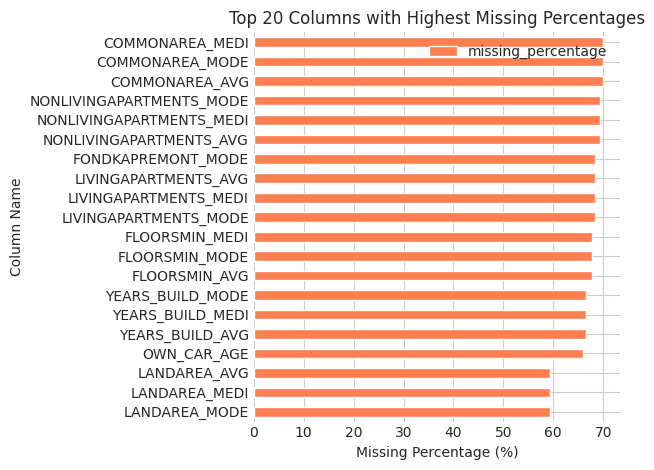


Dropped 49 columns with >40% missing values
New shape: (307511, 73)


In [6]:
if not app_data.empty:
    missing_app = assess_data_quality(app_data, "Application Data")

    # Display top columns with missing values
    if len(missing_app) > 0:
        print("\nTop 20 columns with highest missing percentages:")
        display(missing_app.head(20))

        # Visualize missing values pattern
        plt.figure(figsize=(12, 6))
        missing_app[missing_app['missing_percentage'] > 0].sort_values('missing_percentage', ascending=False).head(20).plot(
            kind='barh', x='column', y='missing_percentage', color='coral')
        plt.title('Top 20 Columns with Highest Missing Percentages')
        plt.xlabel('Missing Percentage (%)')
        plt.ylabel('Column Name')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    # Strategy: Drop columns with > 40% missing values
    if 'Percent' in missing_data(app_data).columns:
        cols_to_drop = missing_data(app_data)[missing_data(app_data)['Percent'] > 40].index
        app_data_clean = app_data.drop(columns=cols_to_drop)
        print(f"\nDropped {len(cols_to_drop)} columns with >40% missing values")
        print(f"New shape: {app_data_clean.shape}")
    else:
        app_data_clean = app_data.copy()
else:
    app_data_clean = app_data

Target Distribution:
0 (No payment difficulties): 282,686 (91.93%)
1 (Payment difficulties): 24,825 (8.07%)


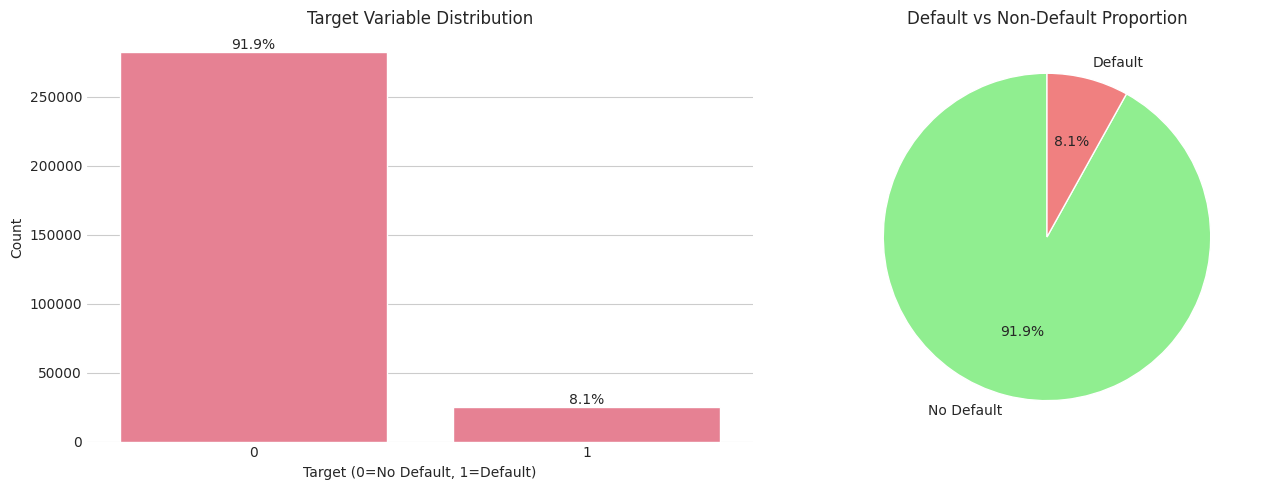


Class Imbalance Ratio (Non-default:Default): 11.39:1
This is a highly imbalanced dataset!


In [7]:
if not app_data.empty and 'TARGET' in app_data.columns:
    target_dist = app_data['TARGET'].value_counts()
    target_percentage = app_data['TARGET'].value_counts(normalize=True) * 100

    print(f"Target Distribution:")
    print(f"0 (No payment difficulties): {target_dist.get(0, 0):,} ({target_percentage.get(0, 0):.2f}%)")
    print(f"1 (Payment difficulties): {target_dist.get(1, 0):,} ({target_percentage.get(1, 0):.2f}%)")

    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Count plot
    sns.countplot(x='TARGET', data=app_data, ax=axes[0])
    axes[0].set_title('Target Variable Distribution')
    axes[0].set_xlabel('Target (0=No Default, 1=Default)')
    axes[0].set_ylabel('Count')

    # Add percentage labels
    total = len(app_data)
    for p in axes[0].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[0].text(p.get_x() + p.get_width() / 2, p.get_height(),
                    percentage, ha='center', va='bottom')

    # Pie chart
    axes[1].pie(target_dist.values, labels=['No Default', 'Default'],
                autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    axes[1].set_title('Default vs Non-Default Proportion')

    plt.tight_layout()
    plt.show()

    # Calculate class imbalance
    imbalance_ratio = target_dist.get(0, 0) / max(target_dist.get(1, 1), 1)
    print(f"\nClass Imbalance Ratio (Non-default:Default): {imbalance_ratio:.2f}:1")
    print("This is a highly imbalanced dataset!")

In [8]:
if not app_data_clean.empty:
    # Convert days to years for better interpretation
    # Age in years (DAYS_BIRTH is negative, so we take absolute value)
    app_data_clean['AGE'] = abs(app_data_clean['DAYS_BIRTH']) / 365.25

    # Employment years (handle anomaly 365243 days = 1000 years)
    app_data_clean['EMPLOYMENT_YEARS'] = app_data_clean['DAYS_EMPLOYED'].apply(
        lambda x: np.nan if x == 365243 else abs(min(x, 0)) / 365.25
    )
    app_data_clean['EMPLOYMENT_ANOMALY'] = (app_data_clean['DAYS_EMPLOYED'] == 365243).astype(int)

    print(f"Number of employment anomalies (365243 days): {app_data_clean['EMPLOYMENT_ANOMALY'].sum()}")
    print(f"Percentage: {(app_data_clean['EMPLOYMENT_ANOMALY'].sum() / len(app_data_clean)) * 100:.2f}%")

    # Create financial ratios
    if all(col in app_data_clean.columns for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY']):
        app_data_clean['CREDIT_INCOME_RATIO'] = app_data_clean['AMT_CREDIT'] / app_data_clean['AMT_INCOME_TOTAL']
        app_data_clean['ANNUITY_INCOME_RATIO'] = app_data_clean['AMT_ANNUITY'] / app_data_clean['AMT_INCOME_TOTAL']
        app_data_clean['ANNUITY_CREDIT_RATIO'] = app_data_clean['AMT_ANNUITY'] / app_data_clean['AMT_CREDIT']

    # Social circle default rates
    if all(col in app_data_clean.columns for col in ['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']):
        app_data_clean['SOCIAL_30_DEFAULT_RATE'] = app_data_clean['DEF_30_CNT_SOCIAL_CIRCLE'] / app_data_clean['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, np.nan)

    print("\nCreated derived features:")
    print("  - AGE (years)")
    print("  - EMPLOYMENT_YEARS (years)")
    print("  - EMPLOYMENT_ANOMALY flag")
    print("  - CREDIT_INCOME_RATIO")
    print("  - ANNUITY_INCOME_RATIO")
    print("  - SOCIAL_30_DEFAULT_RATE")


DATA CLEANING AND FEATURE ENGINEERING
Number of employment anomalies (365243 days): 55374
Percentage: 18.01%

Created derived features:
  - AGE (years)
  - EMPLOYMENT_YEARS (years)
  - EMPLOYMENT_ANOMALY flag
  - CREDIT_INCOME_RATIO
  - ANNUITY_INCOME_RATIO
  - SOCIAL_30_DEFAULT_RATE


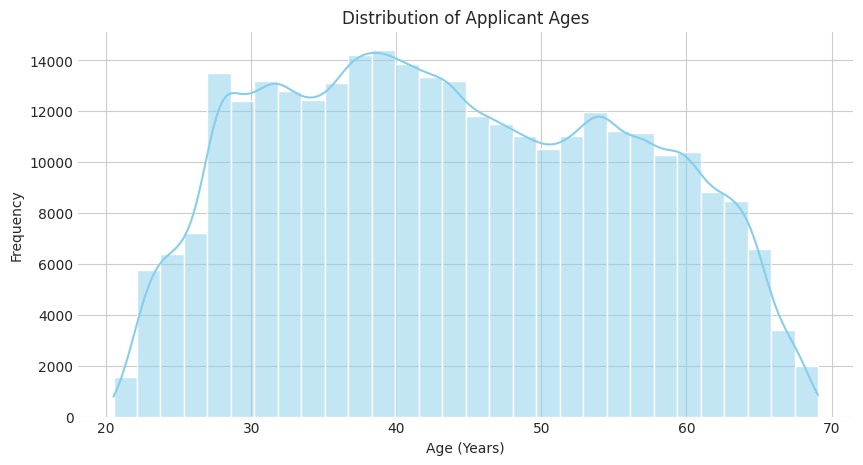

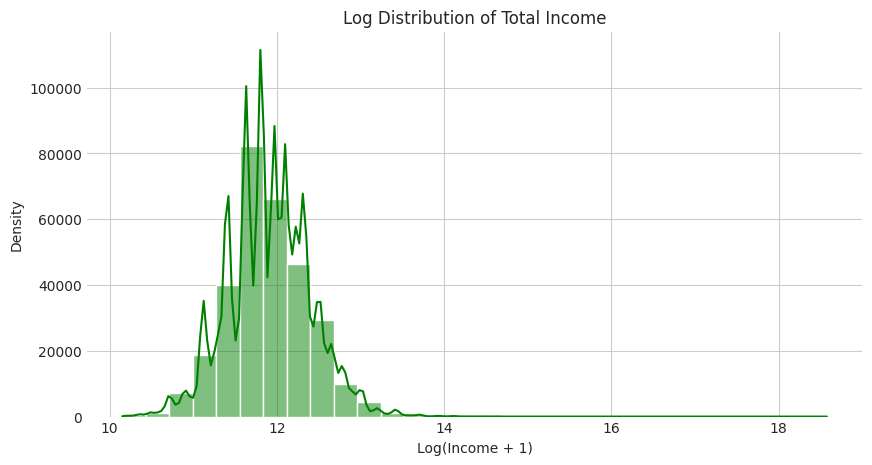

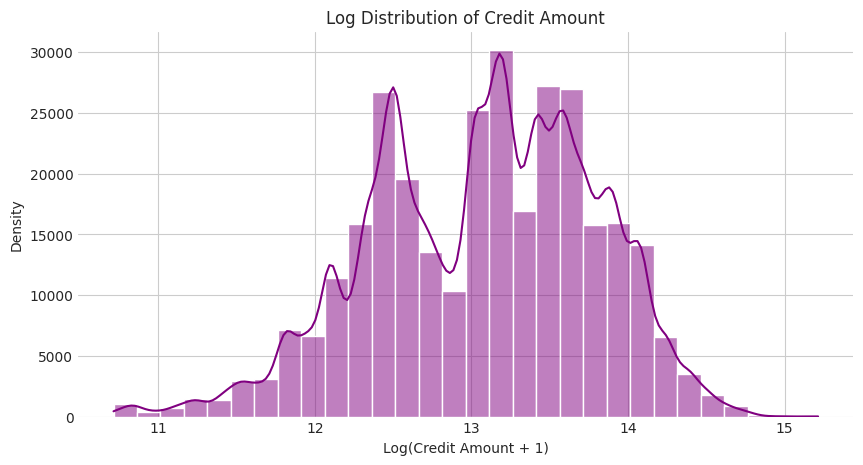

In [9]:
if not app_data_clean.empty:
    # 1. Age Distribution
    plt.figure(figsize=(10,5))
    sns.histplot(app_data_clean['AGE'].dropna(), bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Applicant Ages')
    plt.xlabel('Age (Years)')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Income Distribution (Log scale for better visualization)
    if 'AMT_INCOME_TOTAL' in app_data_clean.columns:
        plt.figure(figsize=(10,5))
        sns.histplot(np.log1p(app_data_clean['AMT_INCOME_TOTAL']), kde=True, color='green', bins=30)
        plt.title('Log Distribution of Total Income')
        plt.xlabel('Log(Income + 1)')
        plt.ylabel('Density')
        plt.show()

    # 3. Credit Amount Distribution
    if 'AMT_CREDIT' in app_data_clean.columns:
        plt.figure(figsize=(10,5))
        sns.histplot(np.log1p(app_data_clean['AMT_CREDIT']), kde=True, color='purple', bins=30)
        plt.title('Log Distribution of Credit Amount')
        plt.xlabel('Log(Credit Amount + 1)')
        plt.ylabel('Density')
        plt.show()


ANALYSIS OF: CODE_GENDER
Unique values: 3


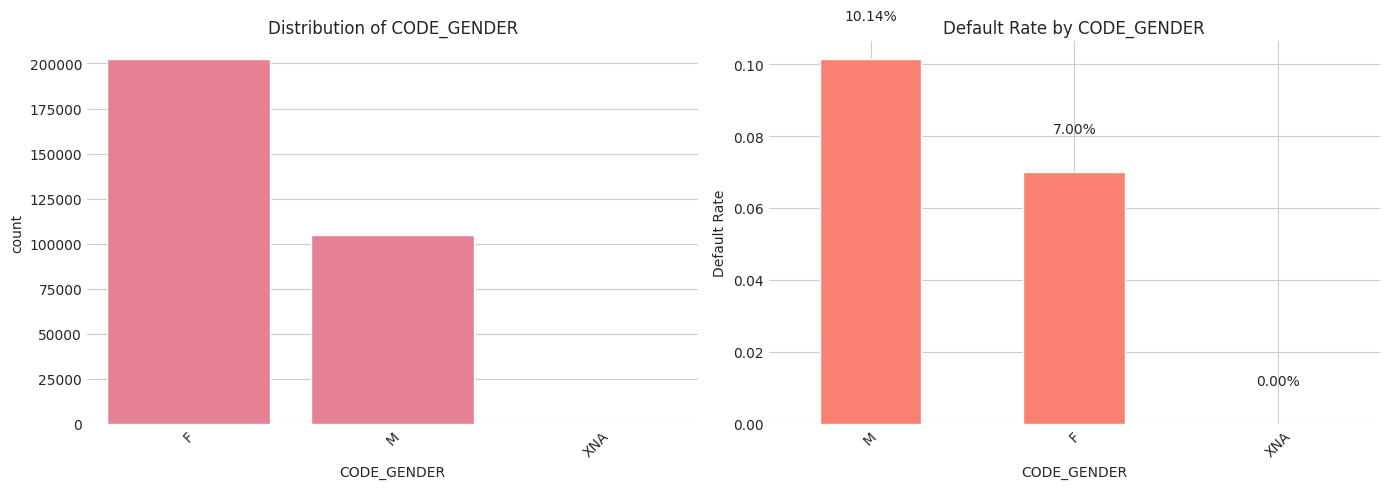


Default Statistics by CODE_GENDER:


,Count,Default_Rate,Default_Count
CODE_GENDER,,,
M,105059,0.101,10655
F,202448,0.070,14170
XNA,4,0.000,0



ANALYSIS OF: FLAG_OWN_CAR
Unique values: 2


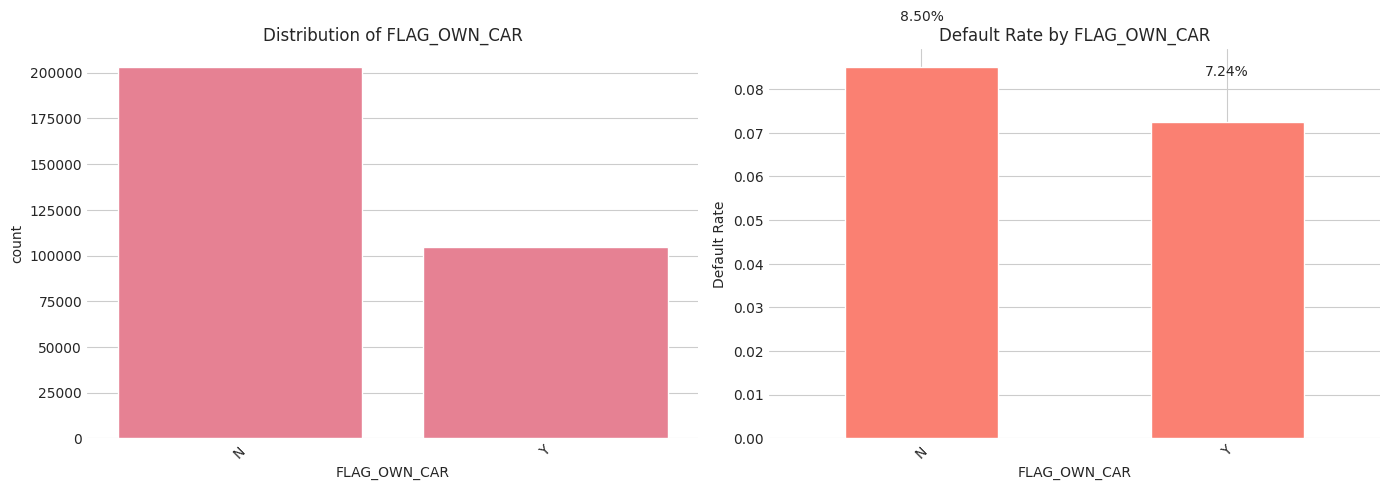


Default Statistics by FLAG_OWN_CAR:


,Count,Default_Rate,Default_Count
FLAG_OWN_CAR,,,
N,202924,0.085,17249
Y,104587,0.072,7576



ANALYSIS OF: FLAG_OWN_REALTY
Unique values: 2


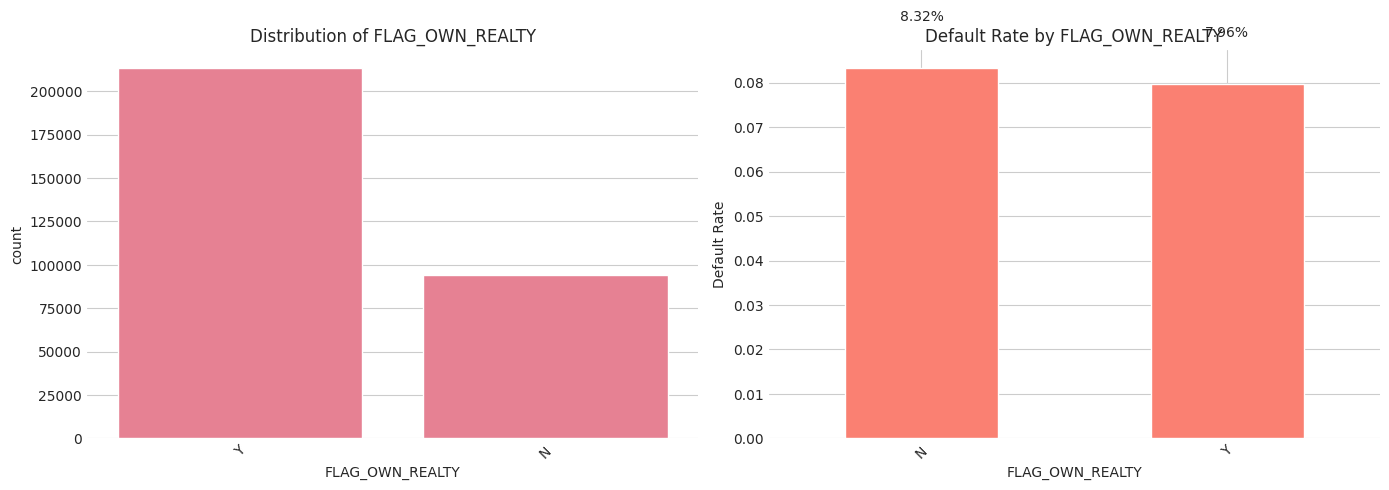


Default Statistics by FLAG_OWN_REALTY:


,Count,Default_Rate,Default_Count
FLAG_OWN_REALTY,,,
N,94199,0.083,7842
Y,213312,0.080,16983



ANALYSIS OF: NAME_INCOME_TYPE
Unique values: 8


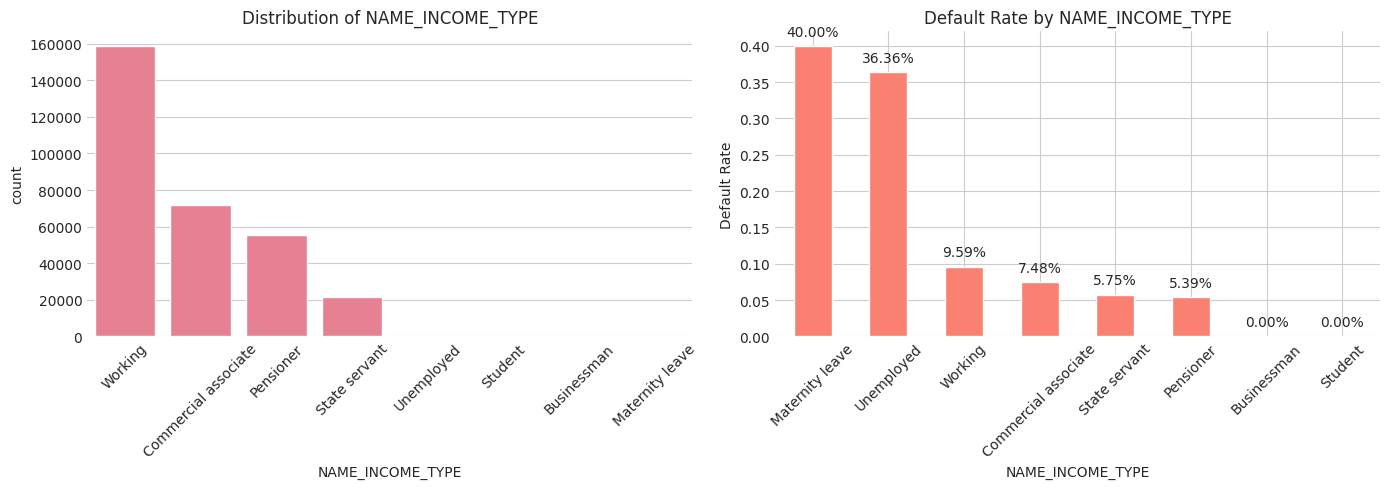


Default Statistics by NAME_INCOME_TYPE:


,Count,Default_Rate,Default_Count
NAME_INCOME_TYPE,,,
Maternity leave,5,0.400,2
Unemployed,22,0.364,8
Working,158774,0.096,15224
Commercial associate,71617,0.075,5360
State servant,21703,0.058,1249
Pensioner,55362,0.054,2982
Businessman,10,0.000,0
Student,18,0.000,0



ANALYSIS OF: NAME_EDUCATION_TYPE
Unique values: 5


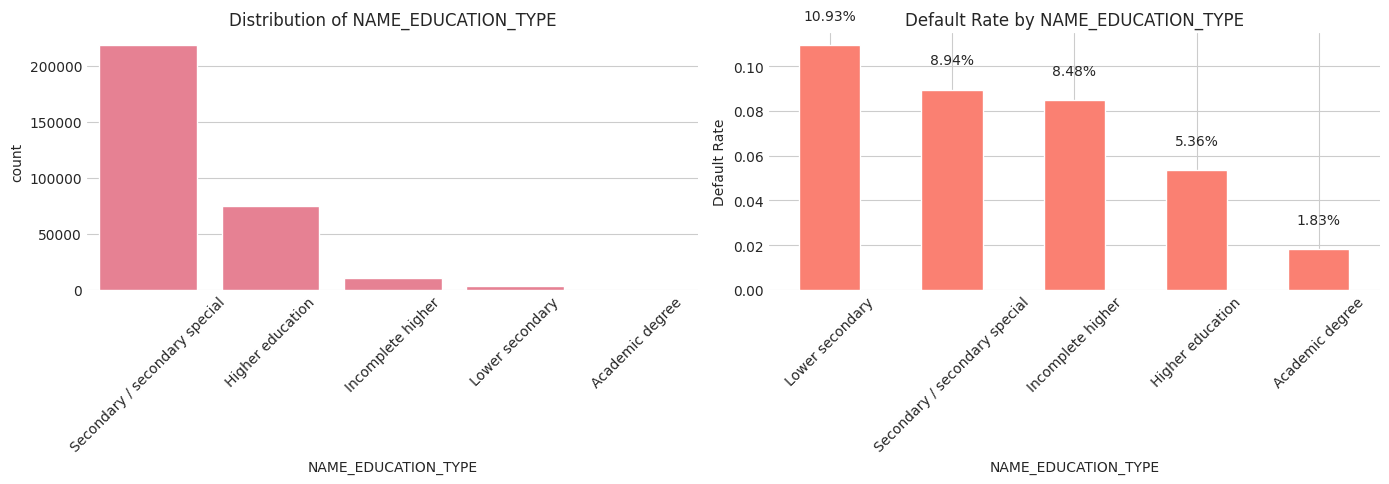


Default Statistics by NAME_EDUCATION_TYPE:


,Count,Default_Rate,Default_Count
NAME_EDUCATION_TYPE,,,
Lower secondary,3816,0.109,417
Secondary / secondary special,218391,0.089,19524
Incomplete higher,10277,0.085,872
Higher education,74863,0.054,4009
Academic degree,164,0.018,3



ANALYSIS OF: NAME_FAMILY_STATUS
Unique values: 6


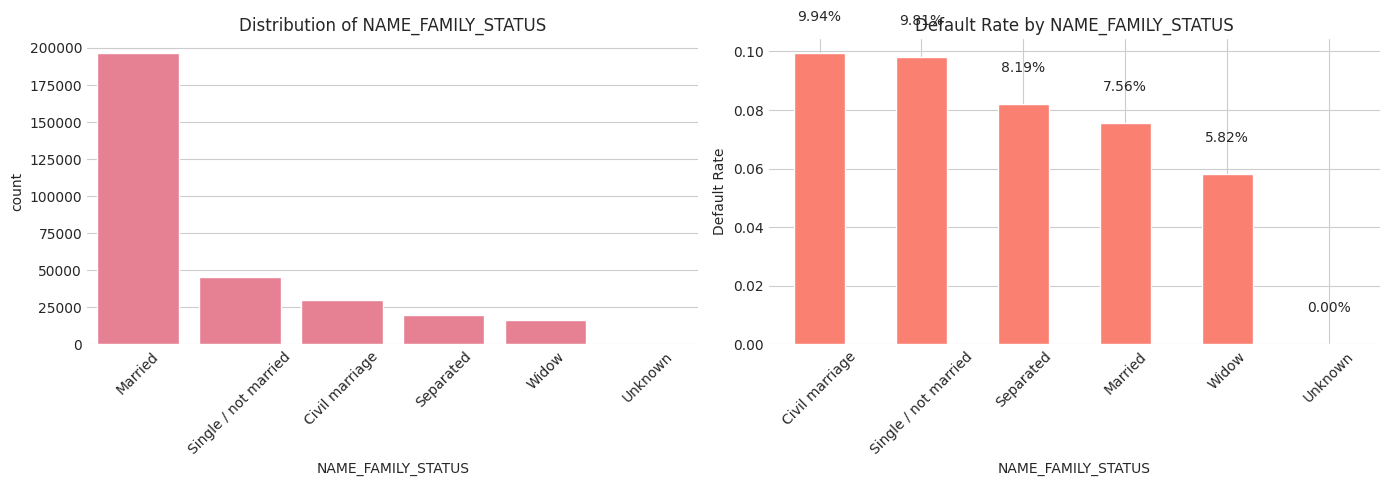


Default Statistics by NAME_FAMILY_STATUS:


,Count,Default_Rate,Default_Count
NAME_FAMILY_STATUS,,,
Civil marriage,29775,0.099,2961
Single / not married,45444,0.098,4457
Separated,19770,0.082,1620
Married,196432,0.076,14850
Widow,16088,0.058,937
Unknown,2,0.000,0



ANALYSIS OF: NAME_HOUSING_TYPE
Unique values: 6


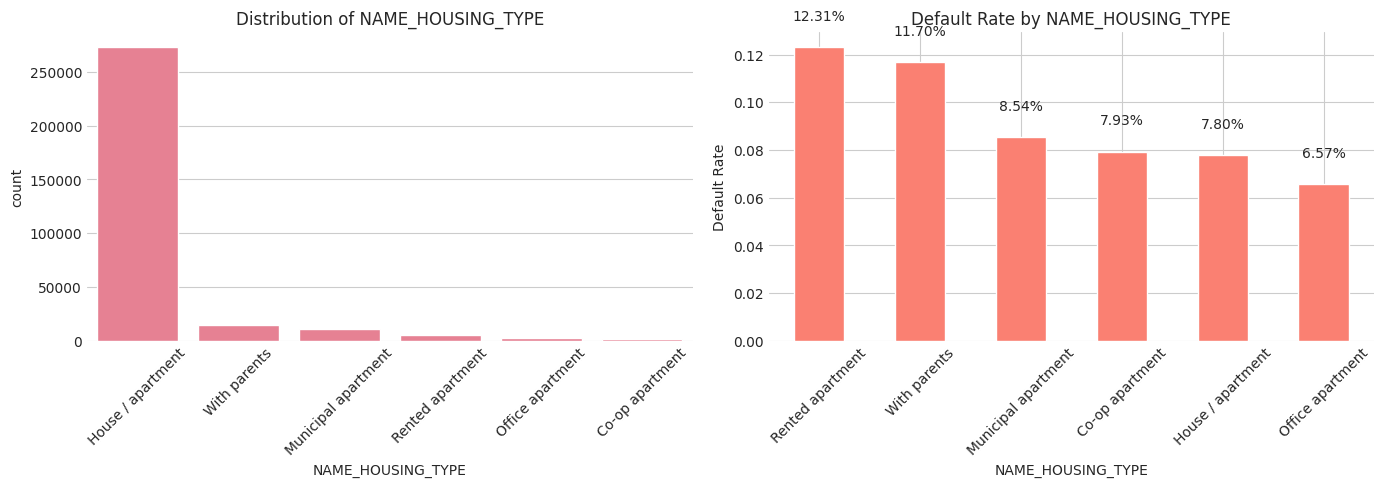


Default Statistics by NAME_HOUSING_TYPE:


,Count,Default_Rate,Default_Count
NAME_HOUSING_TYPE,,,
Rented apartment,4881,0.123,601
With parents,14840,0.117,1736
Municipal apartment,11183,0.085,955
Co-op apartment,1122,0.079,89
House / apartment,272868,0.078,21272
Office apartment,2617,0.066,172



ANALYSIS OF: OCCUPATION_TYPE

Top 10 Occupations by Default Rate:


,Count,Default_Rate,Default_Count
OCCUPATION_TYPE,,,
Low-skill Laborers,2093,0.172,359
Drivers,18603,0.113,2107
Waiters/barmen staff,1348,0.113,152
Security staff,6721,0.107,722
Laborers,55186,0.106,5838
Cooking staff,5946,0.104,621
Sales staff,32102,0.096,3092
Cleaning staff,4653,0.096,447
Realty agents,751,0.079,59


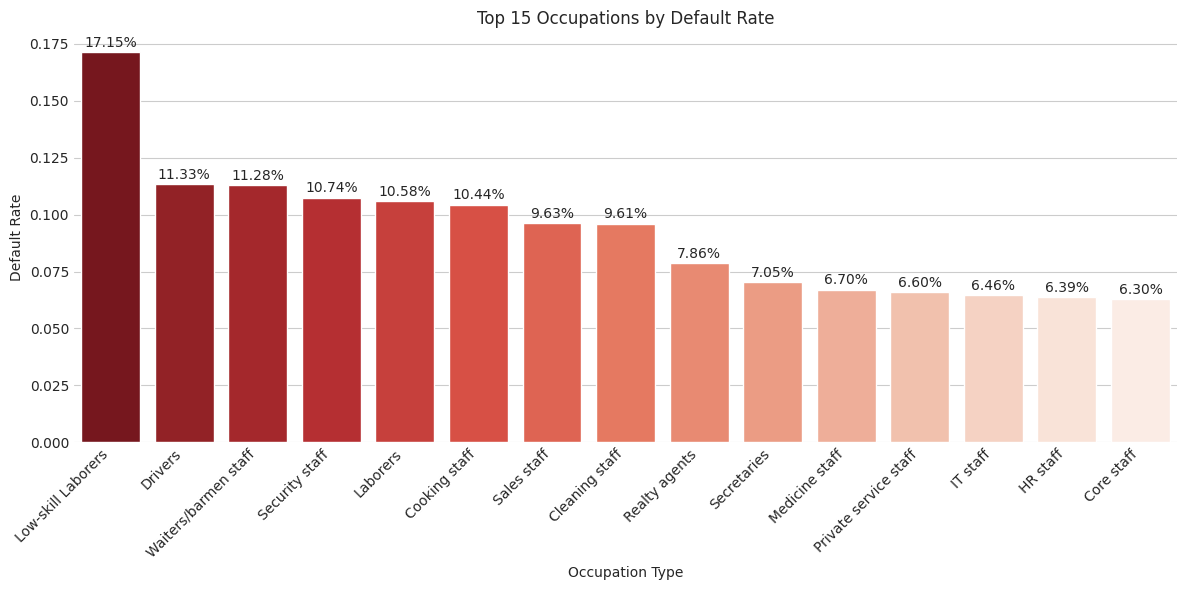

In [10]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Analyze key demographic variables
    demographic_cols = [
        'CODE_GENDER',
        'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY',
        'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE'
    ]

    for col in demographic_cols:
        if col in app_data_clean.columns:
            plot_categorical_analysis(app_data_clean, col)

    # Special analysis for occupation (has many categories)
    if 'OCCUPATION_TYPE' in app_data_clean.columns:
        occupation_stats = app_data_clean.groupby('OCCUPATION_TYPE')['TARGET'].agg(['count', 'mean', 'sum']).round(4)
        occupation_stats.columns = ['Count', 'Default_Rate', 'Default_Count']
        occupation_stats = occupation_stats.sort_values('Default_Rate', ascending=False)

        print("\nTop 10 Occupations by Default Rate:")
        display(occupation_stats.head(10))

        # Plot top 15 occupations by default rate
        plt.figure(figsize=(12, 6))
        top_occupations = occupation_stats.head(15)
        ax = sns.barplot(x=top_occupations.index, y='Default_Rate', data=top_occupations, palette='Reds_r')
        plt.title('Top 15 Occupations by Default Rate')
        plt.xlabel('Occupation Type')
        plt.ylabel('Default Rate')
        plt.xticks(rotation=45, ha='right')

        # Add value labels
        for i, v in enumerate(top_occupations['Default_Rate']):
            ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


Financial Variables Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,missing_pct
AMT_INCOME_TOTAL,307511.000,168797.919,237123.146,25650.000,112500.000,147150.000,202500.000,117000000.000,0.000
AMT_CREDIT,307511.000,599026.000,402490.777,45000.000,270000.000,513531.000,808650.000,4050000.000,0.000
AMT_ANNUITY,307499.000,27108.574,14493.737,1615.500,16524.000,24903.000,34596.000,258025.500,0.004
AMT_GOODS_PRICE,307233.000,538396.207,369446.461,40500.000,238500.000,450000.000,679500.000,4050000.000,0.090
CREDIT_INCOME_RATIO,307511.000,3.958,2.690,0.005,2.019,3.265,5.160,84.737,0.000
ANNUITY_INCOME_RATIO,307499.000,0.181,0.095,0.000,0.115,0.163,0.229,1.876,0.004



AMT_INCOME_TOTAL - Default Rate by Percentile Bins:


,Count,Default_Rate
AMT_INCOME_TOTAL_bin,,
"(67499.999, 90000.0]",47803,8.300
"(90000.0, 103500.0]",9304,8.800
"(103500.0, 112500.0]",33352,8.700
"(112500.0, 135000.0]",48849,8.500
"(135000.0, 144000.0]",4206,9.000
"(144000.0, 157500.0]",29422,8.700
"(157500.0, 180000.0]",32529,8.400
"(180000.0, 211500.0]",22159,8.000
"(211500.0, 247500.0]",29971,7.500


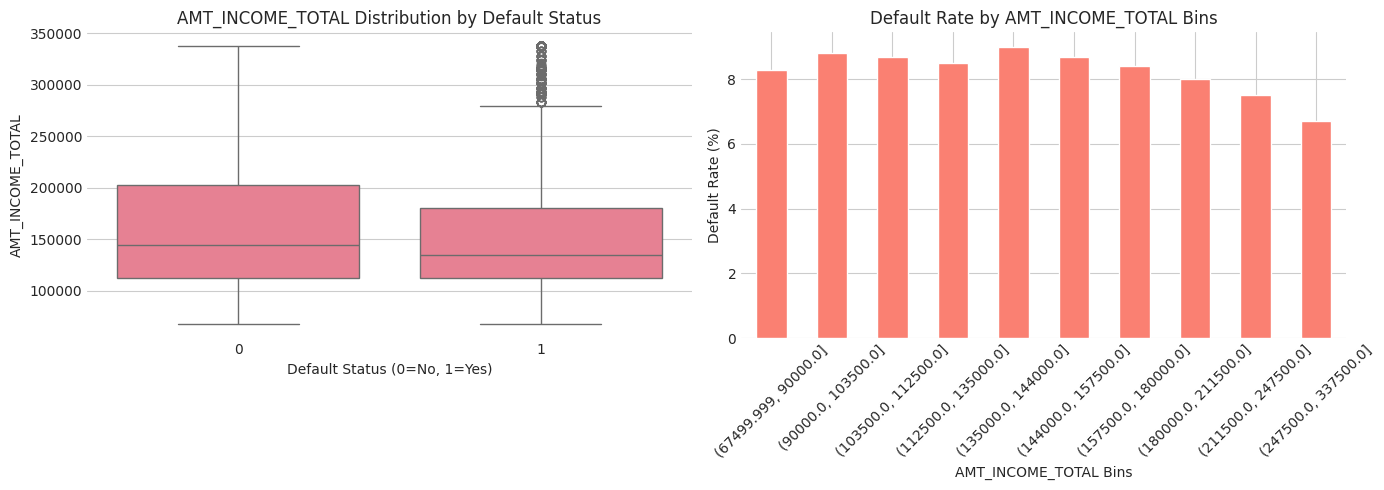


AMT_CREDIT - Default Rate by Percentile Bins:


,Count,Default_Rate
AMT_CREDIT_bin,,
"(134999.999, 208512.0]",28250,7.400
"(208512.0, 265851.0]",28104,7.700
"(265851.0, 315000.0]",30001,8.700
"(315000.0, 440784.0]",26309,10.100
"(440784.0, 509400.0]",28266,9.500
"(509400.0, 592560.0]",29512,10.600
"(592560.0, 711000.0]",26715,8.600
"(711000.0, 838453.5]",28173,7.800
"(838453.5, 1057500.0]",28176,6.800


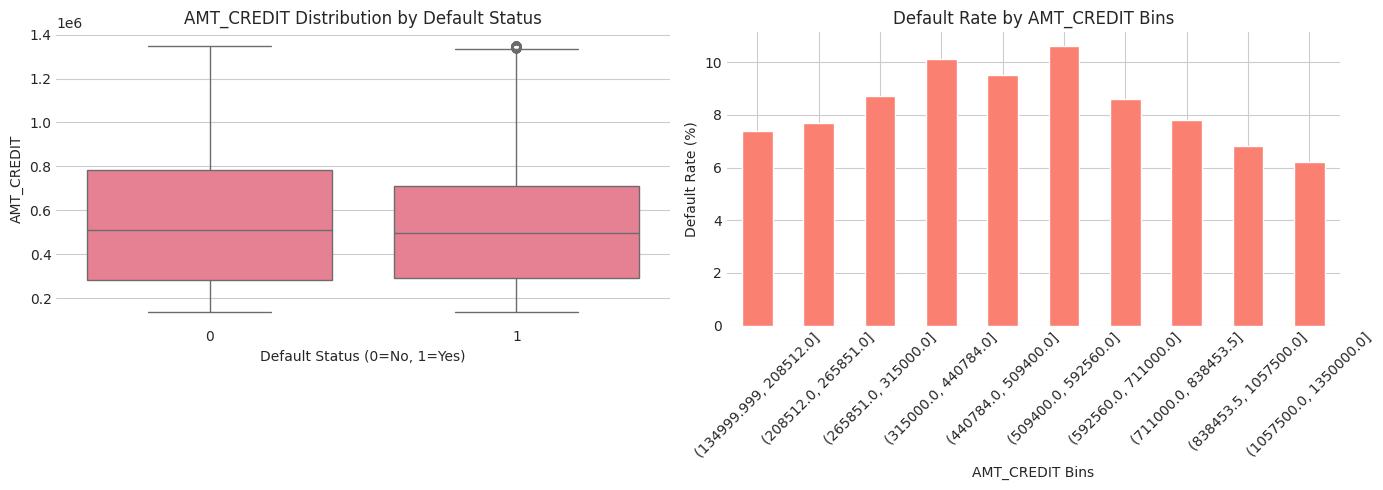


AMT_ANNUITY - Default Rate by Percentile Bins:


,Count,Default_Rate
AMT_ANNUITY_bin,,
"(8999.999, 12510.0]",27905,7.000
"(12510.0, 15750.0]",28001,7.300
"(15750.0, 18904.5]",27749,8.800
"(18904.5, 21919.5]",27891,8.800
"(21919.5, 24799.5]",27913,8.100
"(24799.5, 27472.5]",27834,9.400
"(27472.5, 31261.5]",28414,9.800
"(31261.5, 35730.0]",27351,8.800
"(35730.0, 41800.5]",27959,8.200


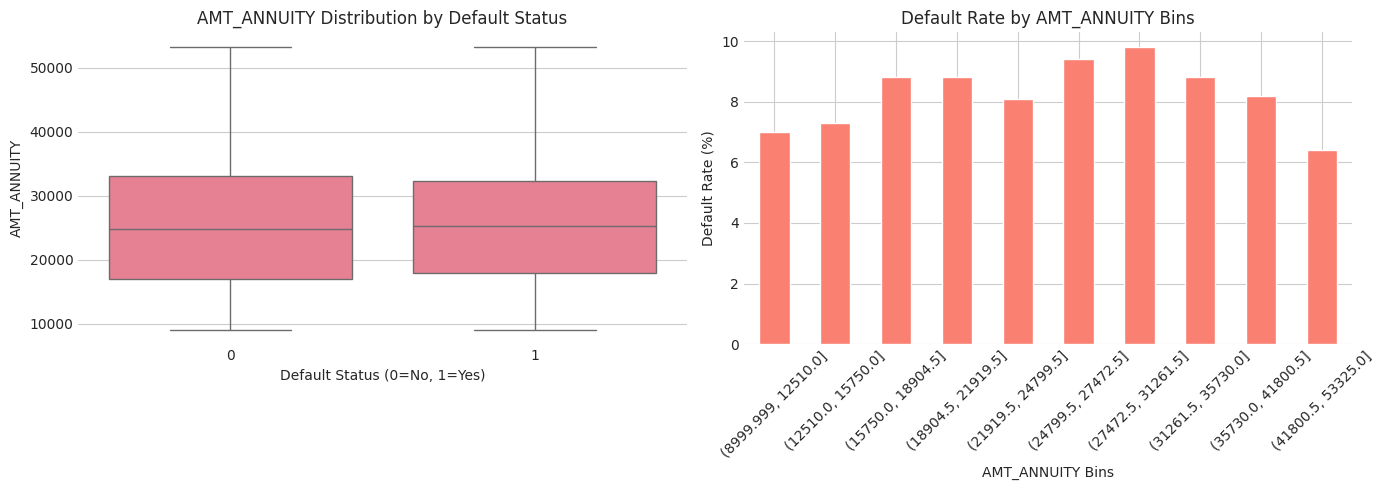


CREDIT_INCOME_RATIO - Default Rate by Percentile Bins:


,Count,Default_Rate
CREDIT_INCOME_RATIO_bin,,
"(0.999, 1.5]",27869,7.300
"(1.5, 1.98]",27712,8.100
"(1.98, 2.368]",27789,8.300
"(2.368, 2.8]",28258,9.000
"(2.8, 3.25]",27450,8.600
"(3.25, 3.82]",27777,9.300
"(3.82, 4.52]",27781,8.600
"(4.52, 5.406]",27728,8.200
"(5.406, 6.667]",28495,7.600


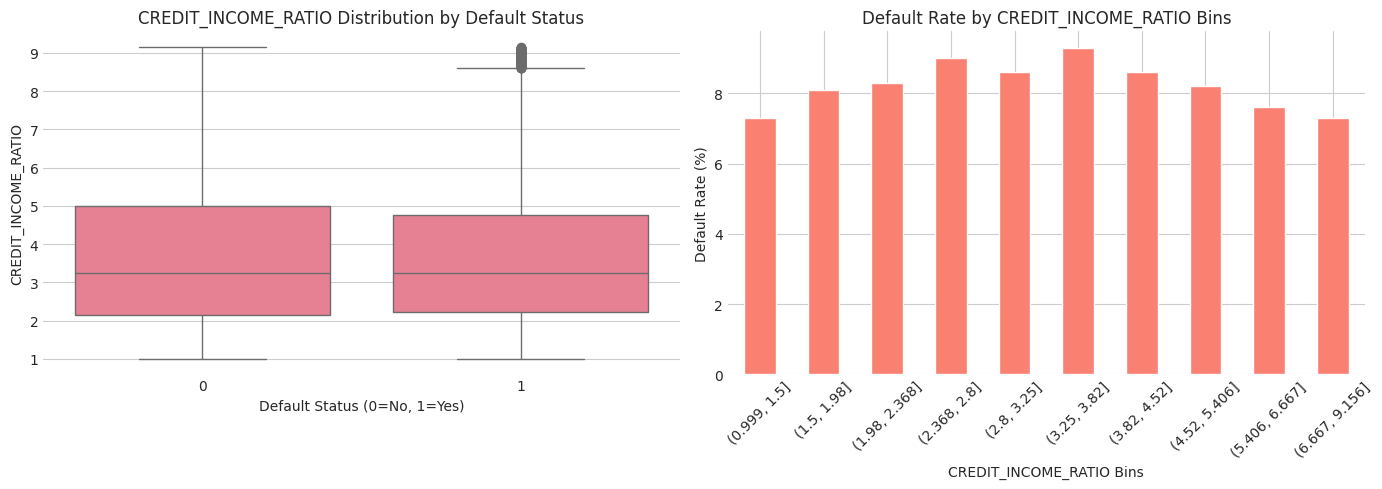

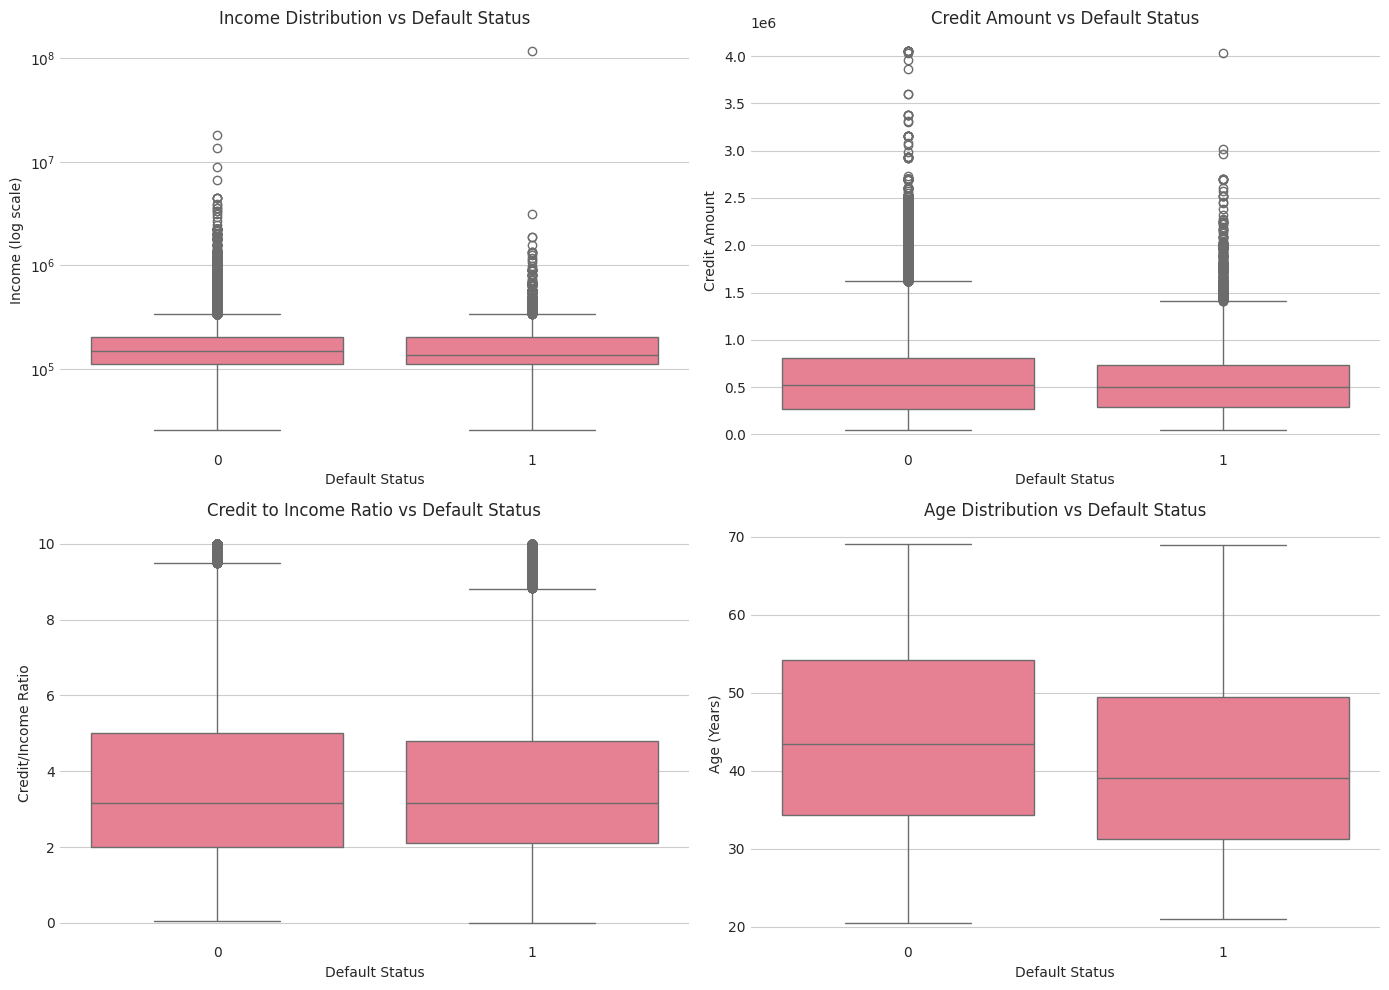

In [11]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # List of key financial variables
    financial_cols = [
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'AMT_GOODS_PRICE',
        'CREDIT_INCOME_RATIO',
        'ANNUITY_INCOME_RATIO'
    ]

    # Create summary statistics
    existing_financial = [col for col in financial_cols if col in app_data_clean.columns]
    if existing_financial:
        financial_stats = app_data_clean[existing_financial].describe().T
        financial_stats['missing_pct'] = (app_data_clean[existing_financial].isnull().sum() / len(app_data_clean)) * 100
        print("\nFinancial Variables Summary Statistics:")
        display(financial_stats)

        # Analyze relationship with target for key financial variables
        for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO']:
            if col in app_data_clean.columns:
                analyze_continuous_variable(app_data_clean, col)

        # Box plots for key financial variables vs target
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Income vs Target
        if 'AMT_INCOME_TOTAL' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_data_clean, ax=axes[0, 0])
            axes[0, 0].set_yscale('log')
            axes[0, 0].set_title('Income Distribution vs Default Status')
            axes[0, 0].set_xlabel('Default Status')
            axes[0, 0].set_ylabel('Income (log scale)')

        # Credit Amount vs Target
        if 'AMT_CREDIT' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AMT_CREDIT', data=app_data_clean, ax=axes[0, 1])
            axes[0, 1].set_title('Credit Amount vs Default Status')
            axes[0, 1].set_xlabel('Default Status')
            axes[0, 1].set_ylabel('Credit Amount')

        # Credit to Income Ratio vs Target
        if 'CREDIT_INCOME_RATIO' in app_data_clean.columns:
            # Filter extreme values for better visualization
            filtered_data = app_data_clean[app_data_clean['CREDIT_INCOME_RATIO'] <= 10]
            sns.boxplot(x='TARGET', y='CREDIT_INCOME_RATIO', data=filtered_data, ax=axes[1, 0])
            axes[1, 0].set_title('Credit to Income Ratio vs Default Status')
            axes[1, 0].set_xlabel('Default Status')
            axes[1, 0].set_ylabel('Credit/Income Ratio')

        # Age vs Target
        if 'AGE' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AGE', data=app_data_clean, ax=axes[1, 1])
            axes[1, 1].set_title('Age Distribution vs Default Status')
            axes[1, 1].set_xlabel('Default Status')
            axes[1, 1].set_ylabel('Age (Years)')

        plt.tight_layout()
        plt.show()

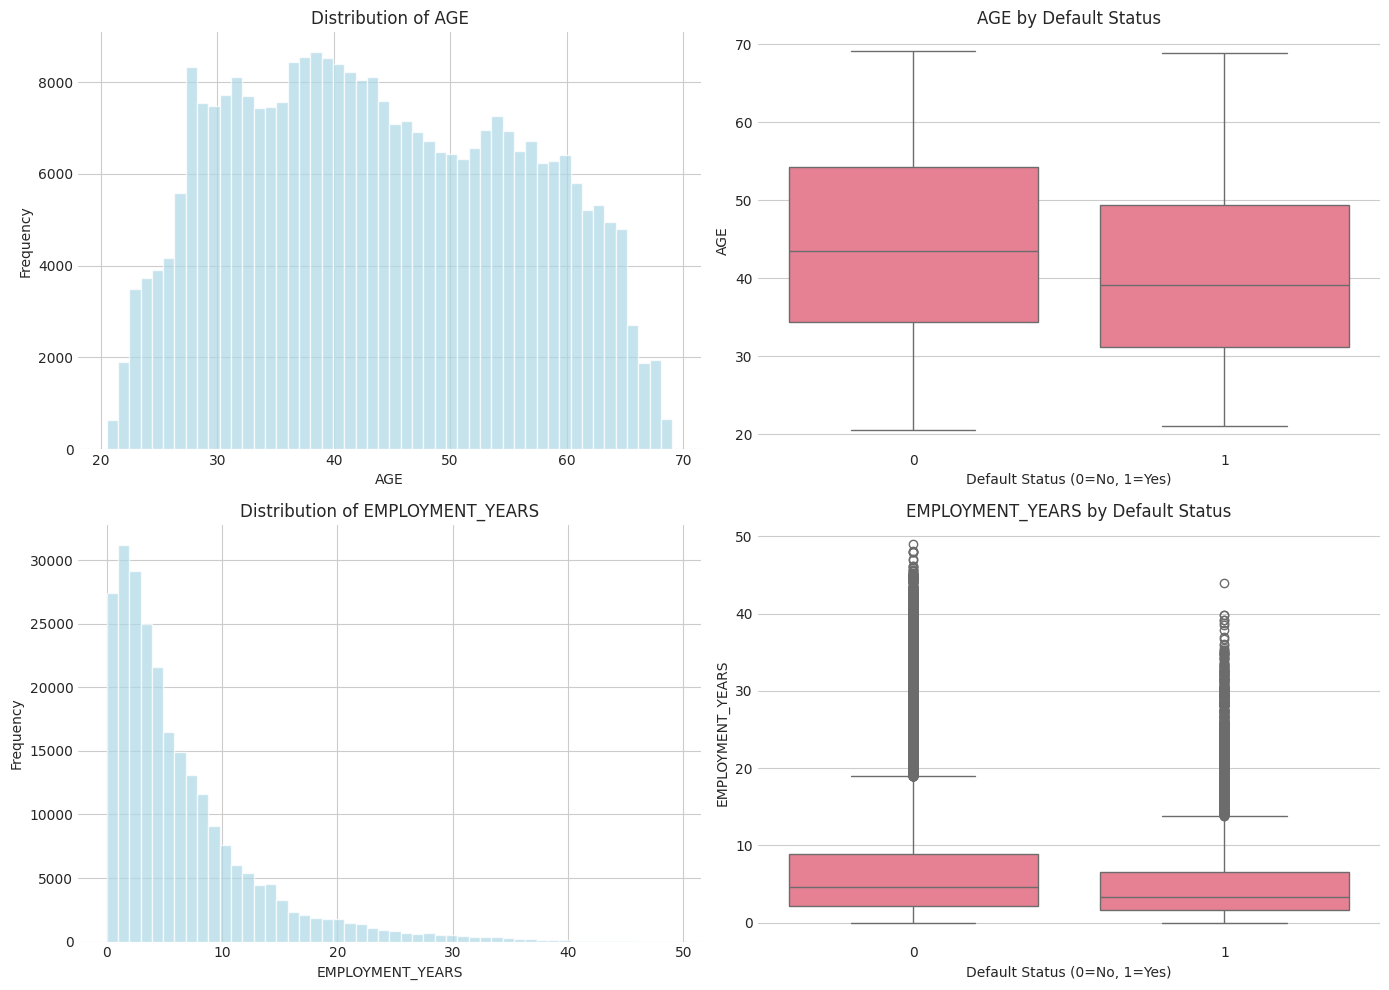


Employment Type Analysis:


,Count,Default_Rate,Default_Count,Median_Income,Median_Age
NAME_INCOME_TYPE,,,,,
Maternity leave,5,40.000,2,90000.000,39.324
Unemployed,22,36.400,8,78750.000,45.829
Working,158774,9.600,15224,135000.000,39.849
Commercial associate,71617,7.500,5360,180000.000,39.754
State servant,21703,5.800,1249,157500.000,40.665
Pensioner,55362,5.400,2982,117000.000,60.372
Businessman,10,0.000,0,495000.000,47.466
Student,18,0.000,0,157500.000,36.638


In [12]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Time-based analysis
    time_cols = ['AGE', 'EMPLOYMENT_YEARS']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for idx, col in enumerate(time_cols):
        if col in app_data_clean.columns:
            # Distribution
            axes[idx, 0].hist(app_data_clean[col].dropna(), bins=50, alpha=0.7, color='lightblue')
            axes[idx, 0].set_title(f'Distribution of {col}')
            axes[idx, 0].set_xlabel(col)
            axes[idx, 0].set_ylabel('Frequency')

            # Box plot by target
            sns.boxplot(x='TARGET', y=col, data=app_data_clean, ax=axes[idx, 1])
            axes[idx, 1].set_title(f'{col} by Default Status')
            axes[idx, 1].set_xlabel('Default Status (0=No, 1=Yes)')
            axes[idx, 1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # Employment type analysis
    if 'NAME_INCOME_TYPE' in app_data_clean.columns:
        employment_analysis = app_data_clean.groupby('NAME_INCOME_TYPE').agg({
            'TARGET': ['count', 'mean', 'sum'],
            'AMT_INCOME_TOTAL': 'median',
            'AGE': 'median'
        }).round(3)

        employment_analysis.columns = ['Count', 'Default_Rate', 'Default_Count',
                                       'Median_Income', 'Median_Age']
        employment_analysis['Default_Rate'] = employment_analysis['Default_Rate'] * 100
        employment_analysis = employment_analysis.sort_values('Default_Rate', ascending=False)

        print("\nEmployment Type Analysis:")
        display(employment_analysis)

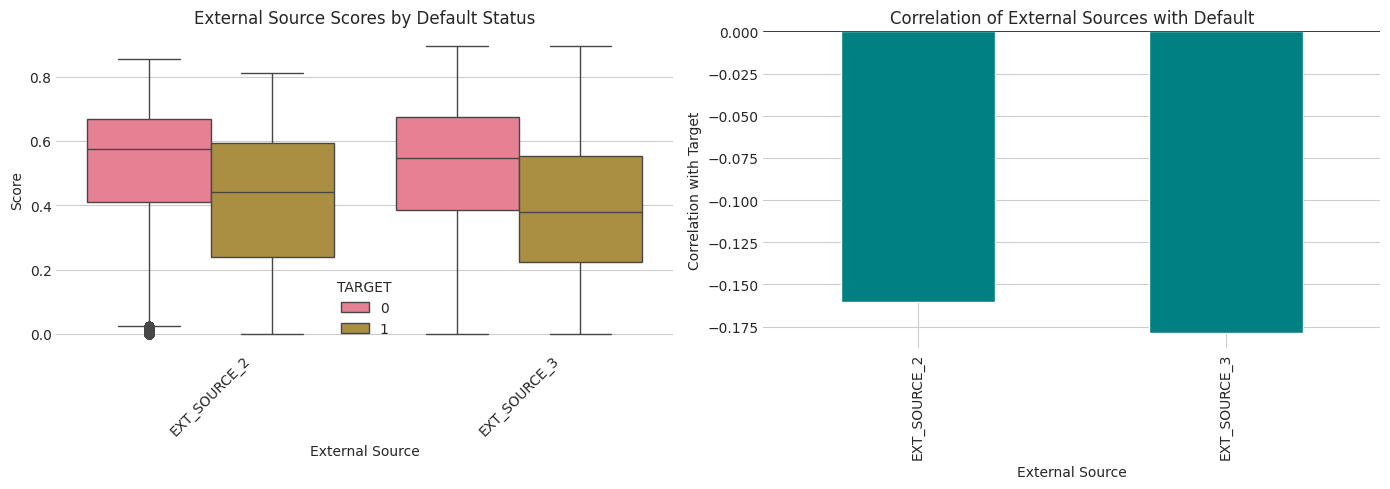


External Source Correlation with Target:


,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,-0.160,-0.179


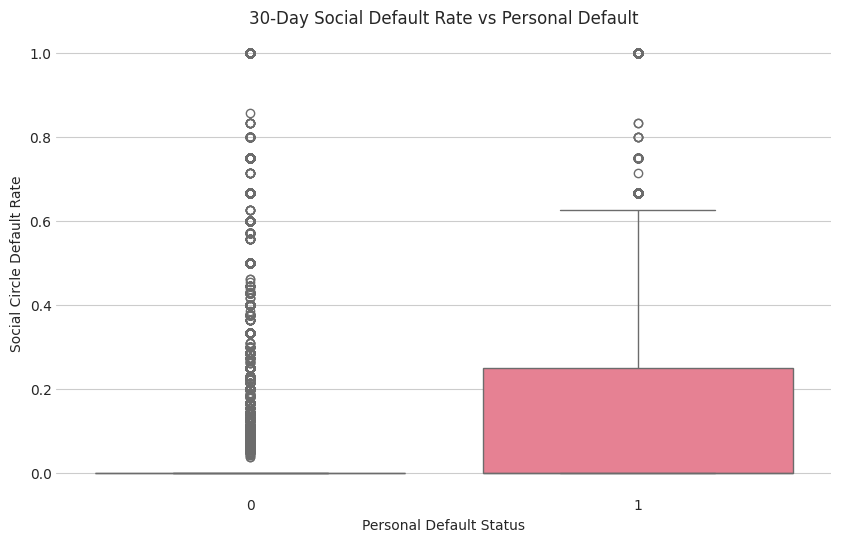

In [13]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # External source scores analysis
    ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    existing_ext = [col for col in ext_source_cols if col in app_data_clean.columns]

    if existing_ext:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Box plot of external scores by target
        ext_data = app_data_clean[existing_ext + ['TARGET']].melt(
            id_vars='TARGET',
            value_vars=existing_ext,
            var_name='Ext_Source',
            value_name='Score'
        )
        sns.boxplot(x='Ext_Source', y='Score', hue='TARGET',
                   data=ext_data, ax=axes[0])
        axes[0].set_title('External Source Scores by Default Status')
        axes[0].set_xlabel('External Source')
        axes[0].set_ylabel('Score')
        axes[0].tick_params(axis='x', rotation=45)

        # Correlation with target
        ext_corr = app_data_clean[existing_ext + ['TARGET']].corr()['TARGET'].drop('TARGET')
        ext_corr.plot(kind='bar', ax=axes[1], color='teal')
        axes[1].set_title('Correlation of External Sources with Default')
        axes[1].set_xlabel('External Source')
        axes[1].set_ylabel('Correlation with Target')
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        plt.tight_layout()
        plt.show()

        print("\nExternal Source Correlation with Target:")
        display(pd.DataFrame(ext_corr).T)

    # Social circle analysis
    if 'SOCIAL_30_DEFAULT_RATE' in app_data_clean.columns:
        plt.figure(figsize=(10, 6))
        mask = app_data_clean['OBS_30_CNT_SOCIAL_CIRCLE'] > 0
        sns.boxplot(x='TARGET', y='SOCIAL_30_DEFAULT_RATE',
                   data=app_data_clean[mask])
        plt.title('30-Day Social Default Rate vs Personal Default')
        plt.xlabel('Personal Default Status')
        plt.ylabel('Social Circle Default Rate')
        plt.show()

Total unique clients in previous applications: 338857
Total previous applications: 1670214
Average applications per client: 4.93

Percentage of clients with previous applications: 459.72%

Previous Application Status Distribution:
Approved: 1,036,781 (62.07%)
Canceled: 316,319 (18.94%)
Refused: 290,678 (17.40%)
Unused offer: 26,436 (1.58%)


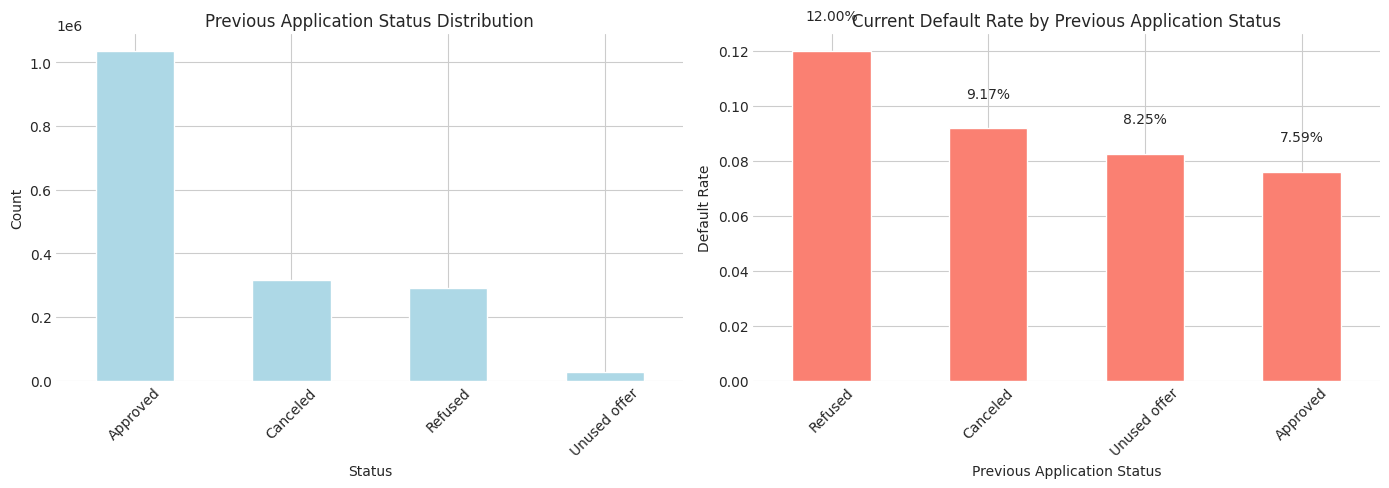


Previous Refusal Impact on Current Default:


,Count,Default_Rate,Default_Count
PREV_REFUSED,,,
0,207217,0.070,14473
1,100294,0.103,10352


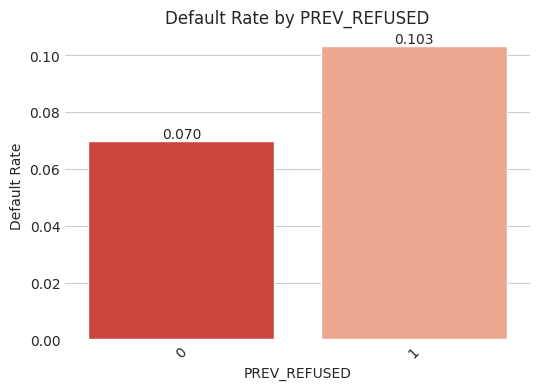

In [14]:
if not prev_app.empty:
    print(f"Total unique clients in previous applications: {prev_app['SK_ID_CURR'].nunique()}")
    print(f"Total previous applications: {len(prev_app)}")
    print(f"Average applications per client: {len(prev_app) / prev_app['SK_ID_CURR'].nunique():.2f}")

    # Merge with application data to see previous loan impact
    if not app_data_clean.empty and 'SK_ID_CURR' in app_data_clean.columns:
        merged_data = pd.merge(
            app_data_clean[['SK_ID_CURR', 'TARGET']],
            prev_app,
            on='SK_ID_CURR',
            how='left'
        )

        print(f"\nPercentage of clients with previous applications: {(merged_data['SK_ID_PREV'].notnull().sum() / len(app_data_clean)) * 100:.2f}%")

        # Analyze previous application status
        if 'NAME_CONTRACT_STATUS' in prev_app.columns:
            prev_status_dist = prev_app['NAME_CONTRACT_STATUS'].value_counts()
            prev_status_pct = prev_app['NAME_CONTRACT_STATUS'].value_counts(normalize=True) * 100

            print("\nPrevious Application Status Distribution:")
            for status, count in prev_status_dist.items():
                print(f"{status}: {count:,} ({prev_status_pct[status]:.2f}%)")

            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Status distribution
            prev_status_dist.plot(kind='bar', ax=axes[0], color='lightblue')
            axes[0].set_title('Previous Application Status Distribution')
            axes[0].set_xlabel('Status')
            axes[0].set_ylabel('Count')
            axes[0].tick_params(axis='x', rotation=45)

            # Analyze how previous status affects current default
            if not merged_data.empty:
                status_default = merged_data.groupby('NAME_CONTRACT_STATUS')['TARGET'].mean().sort_values(ascending=False)
                status_default.plot(kind='bar', ax=axes[1], color='salmon')
                axes[1].set_title('Current Default Rate by Previous Application Status')
                axes[1].set_xlabel('Previous Application Status')
                axes[1].set_ylabel('Default Rate')
                axes[1].tick_params(axis='x', rotation=45)

                # Add value labels
                for i, v in enumerate(status_default.values):
                    axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Create flag for previous refusals
            refused_ids = prev_app[prev_app['NAME_CONTRACT_STATUS'] == 'Refused']['SK_ID_CURR'].unique()
            app_data_clean['PREV_REFUSED'] = app_data_clean['SK_ID_CURR'].isin(refused_ids).astype(int)

            print("\nPrevious Refusal Impact on Current Default:")
            refusal_stats = app_data_clean.groupby('PREV_REFUSED')['TARGET'].agg(['count', 'mean', 'sum'])
            refusal_stats.columns = ['Count', 'Default_Rate', 'Default_Count']
            display(refusal_stats)

            # Plot default rate for those with previous refusals
            plot_default_rate(app_data_clean, 'PREV_REFUSED', figsize=(6, 4))

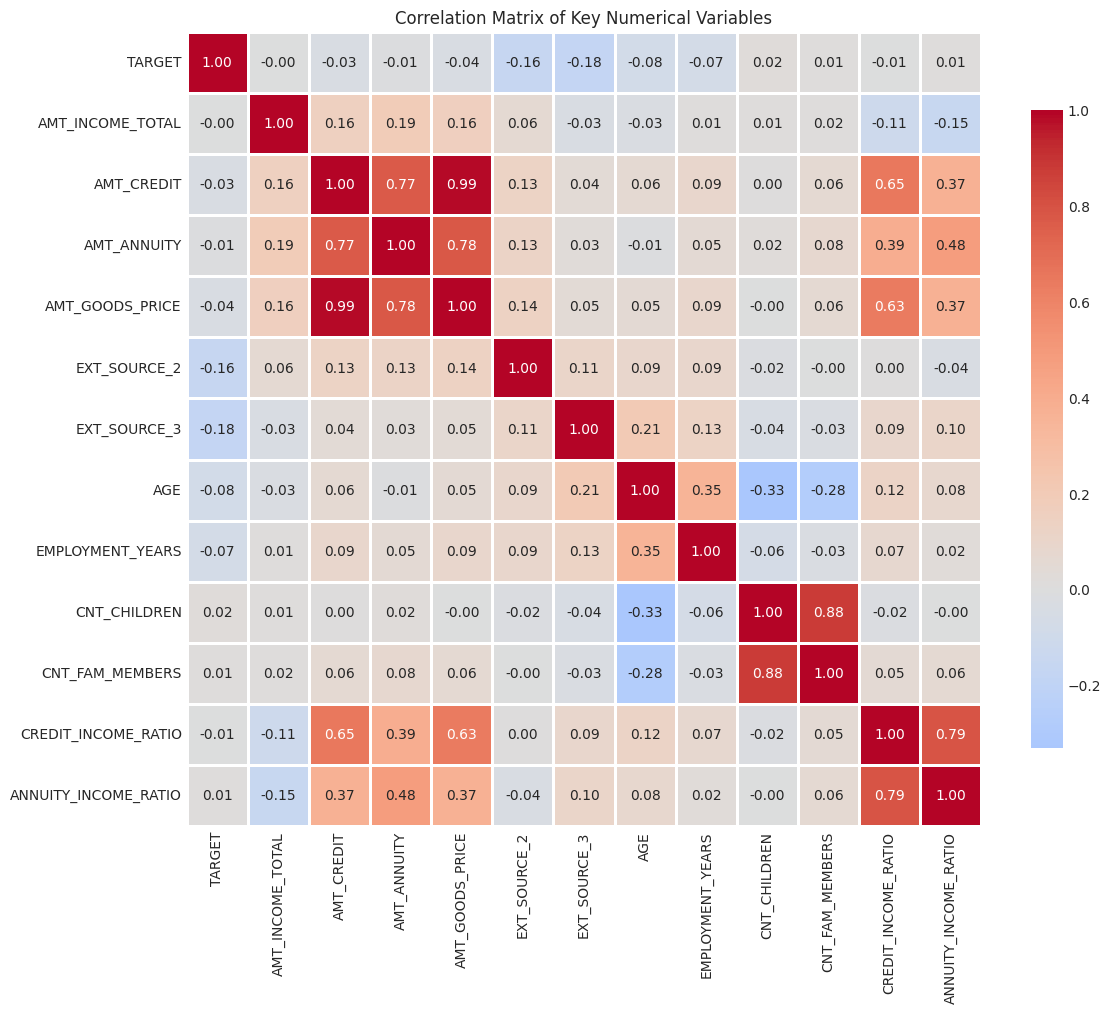


Top 15 Variables Correlated with Target (Absolute Value):


,TARGET
EXT_SOURCE_3,-0.179
EXT_SOURCE_2,-0.160
AGE,-0.078
EMPLOYMENT_YEARS,-0.075
AMT_GOODS_PRICE,-0.040
AMT_CREDIT,-0.030
CNT_CHILDREN,0.019
ANNUITY_INCOME_RATIO,0.014
AMT_ANNUITY,-0.013
CNT_FAM_MEMBERS,0.009


In [15]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Select key numerical variables for correlation
    key_numerical_cols = [
        'TARGET',
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'AMT_GOODS_PRICE',
        'EXT_SOURCE_1',
        'EXT_SOURCE_2',
        'EXT_SOURCE_3',
        'AGE',
        'EMPLOYMENT_YEARS',
        'CNT_CHILDREN',
        'CNT_FAM_MEMBERS',
        'CREDIT_INCOME_RATIO',
        'ANNUITY_INCOME_RATIO'
    ]

    # Filter columns that exist in dataframe
    existing_cols = [col for col in key_numerical_cols if col in app_data_clean.columns]
    corr_data = app_data_clean[existing_cols].copy()

    # Calculate correlation matrix
    corr_matrix = corr_data.corr()

    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Key Numerical Variables')
    plt.tight_layout()
    plt.show()

    # Top correlations with target
    if 'TARGET' in corr_matrix.columns:
        target_corr = corr_matrix['TARGET'].sort_values(key=abs, ascending=False)
        print("\nTop 15 Variables Correlated with Target (Absolute Value):")
        display(target_corr.head(16).iloc[1:])  # Skip TARGET itself

In [16]:
if not app_data_clean.empty:
    # Key numerical variables for outlier detection
    outlier_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'AGE', 'CNT_CHILDREN']

    existing_outlier_cols = [col for col in outlier_cols if col in app_data_clean.columns]

    if existing_outlier_cols:
        outliers = detect_outliers_iqr(app_data_clean, existing_outlier_cols)

        print("\nOutliers Summary (IQR Method, 1.5x IQR):")
        for col in existing_outlier_cols[:5]:  # Show first 5 for brevity
            if col in outliers:
                stats = outliers[col]
                if stats['count'] > 0:
                    print(f"\n{col}:")
                    print(f"  Outliers: {stats['count']:,} ({stats['percentage']:.2f}%)")
                    print(f"  Normal range: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")


Outliers Summary (IQR Method, 1.5x IQR):

AMT_INCOME_TOTAL:
  Outliers: 14,035 (4.56%)
  Normal range: [-22500.00, 337500.00]

AMT_CREDIT:
  Outliers: 6,562 (2.13%)
  Normal range: [-537975.00, 1616625.00]

AMT_ANNUITY:
  Outliers: 7,504 (2.44%)
  Normal range: [-10584.00, 61704.00]

AMT_GOODS_PRICE:
  Outliers: 14,728 (4.79%)
  Normal range: [-423000.00, 1341000.00]


In [17]:
insights = {
    "Dataset Overview": {
        "Total Applications": len(app_data) if not app_data.empty else "N/A",
        "Default Rate": f"{app_data['TARGET'].mean() * 100:.2f}%" if not app_data.empty and 'TARGET' in app_data.columns else "N/A",
        "Class Imbalance": f"{app_data[app_data['TARGET'] == 0].shape[0] / app_data[app_data['TARGET'] == 1].shape[0]:.1f}:1" if not app_data.empty and 'TARGET' in app_data.columns else "N/A"
    },
    "Data Quality": {
        "Application Columns": app_data.shape[1] if not app_data.empty else "N/A",
        "Previous App Columns": prev_app.shape[1] if not prev_app.empty else "N/A",
        "High Missing Columns (>40%)": len(cols_to_drop) if 'cols_to_drop' in locals() else "N/A",
        "Employment Anomalies": f"{app_data_clean['EMPLOYMENT_ANOMALY'].sum():,} cases" if not app_data_clean.empty and 'EMPLOYMENT_ANOMALY' in app_data_clean.columns else "N/A"
    },
    "Key Findings": [
        "1. Dataset is highly imbalanced with only ~8% default cases",
        "2. Several columns have very high missing values (>40%)",
        "3. External source scores show strong correlation with default",
        "4. Income type and education level significantly impact default rates",
        "5. Social circle defaults correlate with personal default probability",
        "6. Previous loan refusals increase current default probability",
        "7. Higher credit-to-income ratios are associated with higher defaults",
        "8. Certain occupations (Laborers, Low-skill Laborers) have highest default rates"
    ]
}

# Display insights
for category, content in insights.items():
    print(f"\n{category}:")
    print("-" * 40)
    if isinstance(content, dict):
        for key, value in content.items():
            print(f"  {key}: {value}")
    else:
        for item in content:
            print(f"  {item}")


Dataset Overview:
----------------------------------------
  Total Applications: 307511
  Default Rate: 8.07%
  Class Imbalance: 11.4:1

Data Quality:
----------------------------------------
  Application Columns: 122
  Previous App Columns: 37
  High Missing Columns (>40%): 49
  Employment Anomalies: 55,374 cases

Key Findings:
----------------------------------------
  1. Dataset is highly imbalanced with only ~8% default cases
  2. Several columns have very high missing values (>40%)
  3. External source scores show strong correlation with default
  4. Income type and education level significantly impact default rates
  5. Social circle defaults correlate with personal default probability
  6. Previous loan refusals increase current default probability
  7. Higher credit-to-income ratios are associated with higher defaults
  8. Certain occupations (Laborers, Low-skill Laborers) have highest default rates
